In [12]:
import qiskit, random, os
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit_aer.noise import depolarizing_error, coherent_unitary_error, mixed_unitary_error, thermal_relaxation_error
from qiskit.providers.aer.noise import NoiseModel, mixed_unitary_error, pauli_error
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit.library import CXGate, RXGate, IGate, ZGate, RZXGate, RZZGate
from qiskit.providers.fake_provider import FakeLima
import itertools

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [13]:
def fix_random_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    print(f'random seed fixed to {seed}')

In [14]:
class AddNoise:
    def __init__(self, backend=FakeLima(), simulator=AerSimulator):
        self.uniform = None
        self.theta = None
        self.add_depolarization = None
        self.add_coherent = None
        self.backend = backend
        self.simulator = simulator
        self.num_qubits = self.backend.configuration().n_qubits
        self.cnot_directions = [list(pair) for pair in self.backend.configuration().coupling_map]

        self.cnot = Operator(CXGate())
        self.up_state = 0.5 * (Operator(IGate()) + Operator(ZGate()))
        self.down_state = 0.5 * (Operator(IGate()) - Operator(ZGate()))

    def add_coherent_noise(self, theta, uniform: bool=False, add_depolarization: bool=True,
                           seed: int=None, add_coherent: bool=True) -> NoiseModel:
        self.theta = theta
        self.uniform = uniform
        self.add_depolarization = add_depolarization
        self.add_coherent = add_coherent
        if seed is not None: fix_random_seed(seed)

        noise_model = NoiseModel.from_backend(self.backend)
        noise_dict = noise_model.to_dict()['errors']

        ind_to_del = []
        for i in range(len(noise_dict)):
            if noise_dict[i]['operations'] == ['cx']:
                ind_to_del += [i]

        for i in sorted(ind_to_del, reverse=True):
            del noise_dict[i]

        new_noise_model = NoiseModel.from_dict({'errors': noise_dict})
        if self.add_coherent:
            new_noise_model = self.cx_over_rotation(new_noise_model)
        else:
            new_noise_model = self.restore_incoherent(new_noise_model)
        modified_backend = self.simulator.from_backend(self.backend, noise_model=new_noise_model)

        return modified_backend, new_noise_model

    def get_over_rotated_cx_uni_err(self, theta):
        over_rotated_cnot = Operator(IGate()).tensor(self.up_state) + 1.0j * Operator(RXGate(np.pi + theta)).tensor(self.down_state)
        err_unitary = over_rotated_cnot @ self.cnot
        return coherent_unitary_error(err_unitary)

    def get_depol_therm_error(self, qubits):
        depol_mag = self.backend.properties().gate_error('cx', qubits)
        gate_time = self.backend.properties().gate_length('cx', qubits)
        depol_err = depolarizing_error(depol_mag, 2)
        t1 = self.backend.properties().t1(qubits[0])
        t2 = self.backend.properties().t2(qubits[0])
        therm_err_q0 = thermal_relaxation_error(t1=t1, t2=t2, time=gate_time)
        t1 = self.backend.properties().t1(qubits[1])
        t2 = self.backend.properties().t2(qubits[1])
        therm_err_q1 = thermal_relaxation_error(t1=t1, t2=t2, time=gate_time)
        return depol_err, therm_err_q0, therm_err_q1

    def cx_over_rotation(self, noise_model: NoiseModel) -> NoiseModel:
        if self.uniform:
            coherent_err = self.get_over_rotated_cx_uni_err(self.theta)
            if self.add_depolarization:
                depol_err, therm_err_q0, therm_err_q1 = self.get_depol_therm_error(self.cnot_directions[0])
                composite_error = coherent_err.compose(depol_err).compose(therm_err_q0).compose(therm_err_q1)
                noise_model.add_all_qubit_quantum_error(composite_error, ['cx'])
            else:
                noise_model.add_all_qubit_quantum_error(coherent_err, ['cx'])
        else:
            thetas = np.random.uniform(0, self.theta, size=len(self.cnot_directions))
            print('thetas', thetas)
            for pair, theta in zip(self.cnot_directions, thetas):
                coherent_err = self.get_over_rotated_cx_uni_err(theta)
                if self.add_depolarization:
                    depol_err, therm_err_q0, therm_err_q1 = self.get_depol_therm_error(pair)
                    composite_error = coherent_err.compose(depol_err).compose(therm_err_q0).compose(therm_err_q1)
                    noise_model.add_quantum_error(composite_error, 'cx', pair)
                else:
                    noise_model.add_quantum_error(coherent_err, 'cx', pair)

        return noise_model

    def restore_incoherent(self, noise_model: NoiseModel) -> NoiseModel:
        for pair in self.cnot_directions:
            depol_err, therm_err_q0, therm_err_q1 = self.get_depol_therm_error(pair)
            composite_error = depol_err.compose(therm_err_q0).compose(therm_err_q1)
            noise_model.add_quantum_error(composite_error, 'cx', pair)

        return noise_model

In [15]:
modified_backend, new_noise_model = AddNoise().add_coherent_noise(seed=0, add_coherent=False, theta=np.pi * 0.04, uniform=False, add_depolarization=True)
new_noise_dict = new_noise_model.to_dict()['errors']
for i in range(len(new_noise_dict)):
    if new_noise_dict[i]['operations'] == ['cx']:
        print(new_noise_dict[i])

random seed fixed to 0
{'type': 'qerror', 'id': 'f11cfdadb5214e5fb06f842be2b28a95', 'operations': ['cx'], 'instructions': [[{'name': 'pauli', 'params': ['II'], 'qubits': [0, 1]}, {'name': 'kraus', 'params': [array([[0.9998241 +0.j, 0.        +0.j],
       [0.        +0.j, 0.99726501+0.j]]), array([[-0.01875525+0.j,  0.        +0.j],
       [ 0.        +0.j,  0.01880338+0.j]]), array([[0.        +0.j, 0.07147676+0.j],
       [0.        +0.j, 0.        +0.j]])], 'qubits': [0]}, {'name': 'kraus', 'params': [array([[-0.9997993 +0.j,  0.        +0.j],
       [ 0.        +0.j, -0.99795917+0.j]]), array([[-0.02003407+0.j,  0.        +0.j],
       [ 0.        +0.j,  0.02007101+0.j]]), array([[0.        +0.j, 0.06061882+0.j],
       [0.        +0.j, 0.        +0.j]])], 'qubits': [0]}], [{'name': 'pauli', 'params': ['IX'], 'qubits': [0, 1]}, {'name': 'kraus', 'params': [array([[0.9998241 +0.j, 0.        +0.j],
       [0.        +0.j, 0.99726501+0.j]]), array([[-0.01875525+0.j,  0.        +0.j],


In [16]:
noise_model = NoiseModel.from_backend(FakeLima())
noise_dict = noise_model.to_dict()['errors']
for i in range(len(noise_dict)):
    if noise_dict[i]['operations'] == ['cx']:
        print(noise_dict[i])

{'type': 'qerror', 'id': 'c20862d35b2b4b518c3640a800364bc0', 'operations': ['cx'], 'instructions': [[{'name': 'id', 'qubits': [0]}, {'name': 'kraus', 'params': [array([[-0.99880047+0.j,  0.        +0.j],
       [ 0.        +0.j, -0.99324828+0.j]]), array([[-0.04896547+0.j,  0.        +0.j],
       [ 0.        +0.j,  0.04923919+0.j]]), array([[0.        +0.j, 0.10503978+0.j],
       [0.        +0.j, 0.        +0.j]])], 'qubits': [1]}], [{'name': 'z', 'qubits': [0]}, {'name': 'kraus', 'params': [array([[-0.99880047+0.j,  0.        +0.j],
       [ 0.        +0.j, -0.99324828+0.j]]), array([[-0.04896547+0.j,  0.        +0.j],
       [ 0.        +0.j,  0.04923919+0.j]]), array([[0.        +0.j, 0.10503978+0.j],
       [0.        +0.j, 0.        +0.j]])], 'qubits': [1]}], [{'name': 'reset', 'qubits': [0]}, {'name': 'kraus', 'params': [array([[-0.99880047+0.j,  0.        +0.j],
       [ 0.        +0.j, -0.99324828+0.j]]), array([[-0.04896547+0.j,  0.        +0.j],
       [ 0.        +0.j,  0.

# Test CX Over-rotation + Compare with FakeLima()

In [17]:
out_00 = []
out_01 = []
out_10 = []
out_11 = []

shots = 2500
theta = np.pi * 0.04
backend = AddNoise().add_coherent_noise(add_coherent=False, theta=theta, uniform=True, add_depolarization=True)[0]

depth = list(range(0, 250, 2))
for ng in tqdm(depth):
    qc = QuantumCircuit(2)
    qc.x(0)
    # qc.x(1)
    for _ in range(ng):
        qc.cnot(0, 1)
    qc.measure_all()

    qc_trans = transpile(qc, backend=backend, optimization_level=0)
    counts = backend.run(qc_trans, shots=shots).result().get_counts()
    out_00.append(counts.get('00', 0) / shots)
    out_01.append(counts.get('10', 0) / shots)  # convert from endian to normal order
    out_10.append(counts.get('01', 0) / shots)  # convert from endian to normal order
    out_11.append(counts.get('11', 0) / shots)

  0%|          | 0/125 [00:00<?, ?it/s]

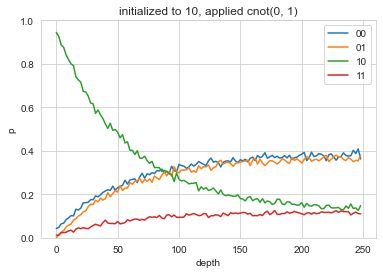

In [158]:
plt.style.use({'figure.facecolor':'white'})
plt.plot(depth, out_00, label='00')
plt.plot(depth, out_01, label='01')
plt.plot(depth, out_10, label='10')
plt.plot(depth, out_11, label='11')
plt.title('initialized to 10, applied cnot(0, 1)')
plt.ylabel('p')
plt.ylim([0, 1])
plt.xlabel('depth')
plt.legend()
plt.show()

In [148]:
out_00 = []
out_01 = []
out_10 = []
out_11 = []

shots = 2500
backend = FakeLima()

depth = list(range(0, 250, 2))
for ng in tqdm(depth):
    qc = QuantumCircuit(2)
    qc.x(0)
    # qc.x(1)
    for _ in range(ng):
        qc.cnot(0, 1)
    qc.measure_all()

    qc_trans = transpile(qc, backend=backend, optimization_level=0)
    counts = backend.run(qc_trans, shots=shots).result().get_counts()
    out_00.append(counts.get('00', 0) / shots)
    out_01.append(counts.get('10', 0) / shots)  # convert from endian to normal order
    out_10.append(counts.get('01', 0) / shots)  # convert from endian to normal order
    out_11.append(counts.get('11', 0) / shots)

  0%|          | 0/125 [00:00<?, ?it/s]

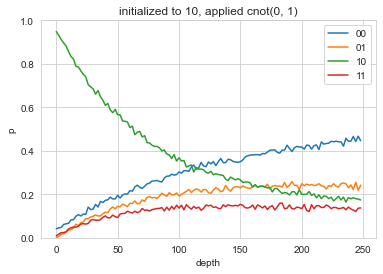

In [149]:
plt.style.use({'figure.facecolor':'white'})
plt.plot(depth, out_00, label='00')
plt.plot(depth, out_01, label='01')
plt.plot(depth, out_10, label='10')
plt.plot(depth, out_11, label='11')
plt.title('initialized to 10, applied cnot(0, 1)')
plt.ylabel('p')
plt.ylim([0, 1])
plt.xlabel('depth')
plt.legend()
plt.show()

In [150]:
out_00 = []
out_01 = []
out_10 = []
out_11 = []

n = 50
shots = 2500
thetas = [4 * np.pi / n * i for i in range(n)]

for theta in tqdm(thetas):
    backend = AddNoise().add_coherent_noise(theta=theta, uniform=True, add_depolarization=True)[0]

    qc = QuantumCircuit(2)
    qc.x(0)
    # qc.x(1)
    qc.cnot(0, 1)
    qc.measure_all()

    qc_trans = transpile(qc, backend=backend, optimization_level=0)
    counts = backend.run(qc_trans, shots=shots).result().get_counts()
    out_00.append(counts.get('00', 0) / shots)
    out_01.append(counts.get('10', 0) / shots)  # convert from endian to normal order
    out_10.append(counts.get('01', 0) / shots)  # convert from endian to normal order
    out_11.append(counts.get('11', 0) / shots)

  0%|          | 0/50 [00:00<?, ?it/s]

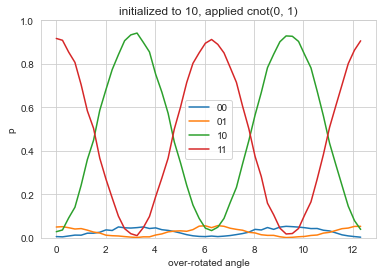

In [151]:
plt.style.use({'figure.facecolor':'white'})
plt.plot(thetas, out_00, label='00')
plt.plot(thetas, out_01, label='01')
plt.plot(thetas, out_10, label='10')
plt.plot(thetas, out_11, label='11')
plt.title('initialized to 10, applied cnot(0, 1)')
plt.ylabel('p')
plt.ylim([0, 1])
plt.xlabel('over-rotated angle')
plt.legend()
plt.show()

# Remove Readout Errors

In [31]:
class RemoveReadoutErrors:
    def __init__(self, backend=FakeLima(), simulator=AerSimulator):
        self.backend = backend
        self.simulator = simulator
        self.num_qubits = self.backend.configuration().n_qubits

    def remove_readout_errors(self) -> NoiseModel:
        noise_model = NoiseModel.from_backend(self.backend)
        noise_dict = noise_model.to_dict()['errors']

        ind_to_del = []
        for i in range(len(noise_dict)):
            if noise_dict[i]['operations'] == ['measure']:
                ind_to_del += [i]

        for i in sorted(ind_to_del, reverse=True):
            del noise_dict[i]

        new_noise_model = NoiseModel.from_dict({'errors': noise_dict})
        modified_backend = self.simulator.from_backend(self.backend, noise_model=new_noise_model)

        return modified_backend, new_noise_model

RRE = RemoveReadoutErrors()
modified_backend = RRE.remove_readout_errors()

In [69]:
out_00 = []
out_01 = []
out_10 = []
out_11 = []

shots = 500
backend = RemoveReadoutErrors().remove_readout_errors()[0]

depth = list(range(0, 250, 2))
for ng in tqdm(depth):
    qc = QuantumCircuit(2)
    qc.measure_all()

    qc_trans = transpile(qc, backend=backend, optimization_level=0)
    counts = backend.run(qc_trans, shots=shots).result().get_counts()
    out_00.append(counts.get('00', 0) / shots)
    out_01.append(counts.get('10', 0) / shots)  # convert from endian to normal order
    out_10.append(counts.get('01', 0) / shots)  # convert from endian to normal order
    out_11.append(counts.get('11', 0) / shots)

print(np.mean(out_00), np.std(out_00))

  0%|          | 0/125 [00:00<?, ?it/s]

1.0 0.0


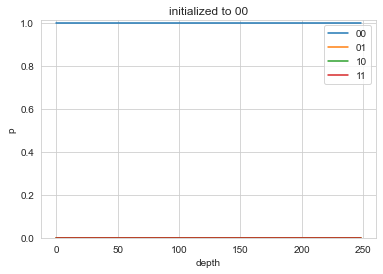

In [70]:
plt.style.use({'figure.facecolor':'white'})
plt.plot(depth, out_00, label='00')
plt.plot(depth, out_01, label='01')
plt.plot(depth, out_10, label='10')
plt.plot(depth, out_11, label='11')
plt.title('initialized to 00')
plt.ylabel('p')
plt.ylim([0, 1.01])
plt.xlabel('depth')
plt.legend()
plt.show()

In [71]:
out_00 = []
out_01 = []
out_10 = []
out_11 = []

shots = 10000
backend = FakeLima()

depth = list(range(0, 250, 2))
for ng in tqdm(depth):
    qc = QuantumCircuit(2)
    qc.measure_all()

    qc_trans = transpile(qc, backend=backend, optimization_level=0)
    counts = backend.run(qc_trans, shots=shots).result().get_counts()
    out_00.append(counts.get('00', 0) / shots)
    out_01.append(counts.get('10', 0) / shots)  # convert from endian to normal order
    out_10.append(counts.get('01', 0) / shots)  # convert from endian to normal order
    out_11.append(counts.get('11', 0) / shots)

print(np.mean(out_00), np.std(out_00))

  0%|          | 0/125 [00:00<?, ?it/s]

0.977292 0.0015821302095592501


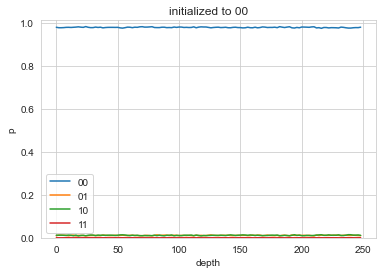

In [72]:
plt.style.use({'figure.facecolor': 'white'})
plt.plot(depth, out_00, label='00')
plt.plot(depth, out_01, label='01')
plt.plot(depth, out_10, label='10')
plt.plot(depth, out_11, label='11')
plt.title('initialized to 00')
plt.ylabel('p')
plt.ylim([0, 1.01])
plt.xlabel('depth')
plt.legend()
plt.show()